### House Price Prediction Problem Assignment:

A US-based housing company named Surprise Housing has decided to enter the Australian market. 
The company uses data analytics to purchase houses at a price below their actual values and flip them at a higher price. The 
company wants to know 

* Which variables are significant in predicting the price of a house, and
* How well those variables describe the price of a house.

Based on various market surveys, the consulting firm has gathered a large dataset of different types of cars across the American market. 

### Methos:

* Build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether 
  to invest in them or not.
* Determine the optimal value of lambda for ridge and lasso regression.


##  Reading and Understanding the Data

In [660]:
# Importing all required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 4000

In [661]:
# Importing dataset

first = pd.read_csv('train.csv')
first.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


##  Data Cleaning 

In [662]:
first.set_index("Id",inplace=True)

#### Removing Null values in Categorical attributes

In [663]:
# check for null values in all categorical columns

first.select_dtypes(include='object').isnull().sum()[first.select_dtypes(include='object').isnull().sum()>0]

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [664]:
# Replace NA with None: 

for col in ('Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Electrical'):
    
    first[col]=first[col].fillna('None')

#### Remove categorical attributes that have more than 85% data associated to one value.

In [665]:


def CategoricalValueCounts():
    column = []
    categorical_columns = first.select_dtypes(include=['object'])
    for col in (categorical_columns):
        if(first[col].value_counts().max() >= (0.85*len(first.index))):
            column.append(col)
    return column

columnsToBeRemoved = CategoricalValueCounts()

# Remove the columns with skewed data

first.drop(columnsToBeRemoved, axis = 1, inplace = True)

first.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,0,0,0,0,None,0,2,2008,Normal,208500
2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,0,0,0,0,None,0,5,2007,Normal,181500
3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,0,0,0,0,None,0,9,2008,Normal,223500
4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,272,0,0,0,None,0,2,2006,Abnorml,140000
5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,0,0,0,0,None,0,12,2008,Normal,250000


#### Removing null values in Numerical varaibles

In [666]:
#first


first.select_dtypes(include=['int64','float']).isnull().sum()[first.select_dtypes(include=['int64','float']).isnull()
                                                                  .sum()>0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [667]:
# Impute the null values with median values for LotFrontage and MasVnrArea columns

first['LotFrontage'] = first['LotFrontage'].replace(np.nan, first['LotFrontage'].median())
first['MasVnrArea'] = first['MasVnrArea'].replace(np.nan, first['MasVnrArea'].median())

In [668]:
# Setting the null values with 0 for GarageYrBlt for now as we would be handling this column further below

first['GarageYrBlt']=first['GarageYrBlt'].fillna(0)
first['GarageYrBlt'] = first['GarageYrBlt'].astype(int)

In [669]:
# Create a new column named BuiltOrRemodelledAge and determine the age of the building at the time of selling

def getBuiltAge(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return row['YrSold'] - row['YearBuilt']
    else:
        return row['YrSold'] - row['YearRemodAdd']
       
first['Age'] = first.apply(getBuiltAge, axis=1)
first.head()  

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,Age
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,0,0,0,None,0,2,2008,Normal,208500,5
2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,0,0,0,None,0,5,2007,Normal,181500,31
3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,0,0,0,None,0,9,2008,Normal,223500,6
4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,0,0,0,None,0,2,2006,Abnorml,140000,36
5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,0,0,0,None,0,12,2008,Normal,250000,8


In [670]:
def checkForRemodel(row):
    if(row['YearBuilt'] == row['YearRemodAdd']):
        return 0
    elif(row['YearBuilt'] < row['YearRemodAdd']):
        return 1
    else:
        return 2
    
first['IsRemodelled'] = first.apply(checkForRemodel, axis=1)
first.head()    

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,Age,IsRemodelled
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,0,0,None,0,2,2008,Normal,208500,5,0
2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,0,0,None,0,5,2007,Normal,181500,31,0
3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,0,0,None,0,9,2008,Normal,223500,6,1
4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,0,0,None,0,2,2006,Abnorml,140000,36,1
5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,0,0,None,0,12,2008,Normal,250000,8,0


In [671]:
def getGarageConstructionPeriod(row):
    if row == 0:
        return 0
    elif row >= 1900 and row < 2000:        
        return 0
    else:   
        return 1
    
first['OldOrNewGarage'] = first['GarageYrBlt'].apply(getGarageConstructionPeriod)
first.head() 

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,Age,IsRemodelled,OldOrNewGarage
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,0,None,0,2,2008,Normal,208500,5,0,1
2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,0,None,0,5,2007,Normal,181500,31,0,0
3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,0,None,0,9,2008,Normal,223500,6,1,1
4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,0,None,0,2,2006,Abnorml,140000,36,1,0
5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,0,None,0,12,2008,Normal,250000,8,0,1


In [672]:
# Since we have created new features from YearBuilt, YearRemodAdd, YrSold and GarageYrBlt, we can drop these columns as we 
# would only be using the derived columns for further analysis

first.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis = 1, inplace = True)

#### Remove numerical attributes that have more than 85% data associated to one value.

In [673]:
# Drop the following columns that have more than 85% values associated to a specific value

def NumericalValueCounts():
    column = []
    numerical_columns = first.select_dtypes(include=['int64', 'float'])
    for col in (numerical_columns):
        if(first[col].value_counts().max() >= 1241):
            column.append(col)
    return column

remove_col = NumericalValueCounts()
first.drop(remove_col, axis = 1, inplace = True)

first.drop(['MoSold'], axis = 1, inplace = True)

first.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,Age,IsRemodelled,OldOrNewGarage
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,2,548,0,61,None,Normal,208500,5,0,1
2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,2,460,298,0,None,Normal,181500,31,0,0
3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,2,608,0,42,None,Normal,223500,6,1,1
4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,3,642,0,35,None,Abnorml,140000,36,1,0
5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,3,836,192,84,None,Normal,250000,8,0,1


In [674]:
# check for percentage of null values in each column

missing = round(100*(first.isnull().sum()/len(first.index)), 2)
print(missing)

MSSubClass        0.0
MSZoning          0.0
LotFrontage       0.0
LotArea           0.0
LotShape          0.0
LotConfig         0.0
Neighborhood      0.0
BldgType          0.0
HouseStyle        0.0
OverallQual       0.0
OverallCond       0.0
RoofStyle         0.0
Exterior1st       0.0
Exterior2nd       0.0
MasVnrType        0.0
MasVnrArea        0.0
ExterQual         0.0
Foundation        0.0
BsmtQual          0.0
BsmtExposure      0.0
BsmtFinType1      0.0
BsmtFinSF1        0.0
BsmtUnfSF         0.0
TotalBsmtSF       0.0
HeatingQC         0.0
1stFlrSF          0.0
2ndFlrSF          0.0
GrLivArea         0.0
BsmtFullBath      0.0
FullBath          0.0
HalfBath          0.0
BedroomAbvGr      0.0
KitchenQual       0.0
TotRmsAbvGrd      0.0
Fireplaces        0.0
FireplaceQu       0.0
GarageType        0.0
GarageFinish      0.0
GarageCars        0.0
GarageArea        0.0
WoodDeckSF        0.0
OpenPorchSF       0.0
Fence             0.0
SaleCondition     0.0
SalePrice         0.0
Age       

Hence there are no null values in the dataset

#### Check for Duplicates

In [675]:
# Check if there are any duplicate values in the dataset

first[first.duplicated(keep=False)]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,Fence,SaleCondition,SalePrice,Age,IsRemodelled,OldOrNewGarage
Id,,,,,,,,,,,,,,,,,,,,,


No duplicate entries found !!!

#### Outlier Treatment

In [676]:
# Checking outliers at 25%,50%,75%,90%,95% and above

housingInfo.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,...,1.767123,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,181.066207,456.098091,161.319273,441.866955,...,0.747315,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,...,2.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,166.000000,712.250000,0.000000,808.000000,...,2.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000
90%,1314.100000,120.000000,96.000000,14381.700000,8.000000,7.000000,335.000000,1065.500000,117.200000,1232.000000,...,3.000000,262.000000,130.000000,112.000000,0.000000,0.000000,0.000000,0.000000,10.000000,278000.000000
95%,1387.050000,160.000000,107.000000,17401.150000,8.000000,8.000000,456.000000,1274.000000,396.200000,1468.000000,...,3.000000,335.000000,175.050000,180.150000,0.000000,160.000000,0.000000,0.000000,11.000000,326100.000000
99%,1445.410000,190.000000,141.000000,37567.640000,10.000000,9.000000,791.920000,1572.410000,830.380000,1797.050000,...,3.000000,505.460000,285.820000,261.050000,168.000000,268.050000,0.000000,700.000000,12.000000,442567.010000


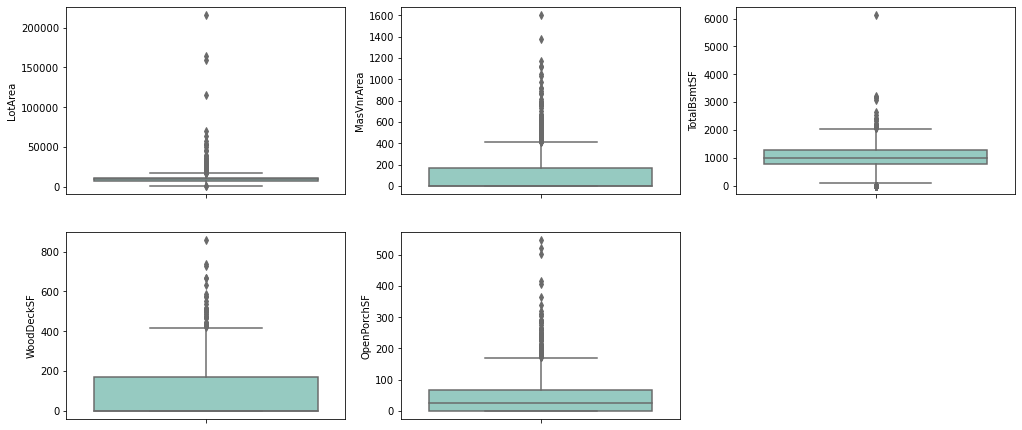

In [677]:
# Check the outliers in all the numeric columns

plt.figure(figsize=(17, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', palette='Set3', data = first)
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', palette='Set3', data = first)
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', palette='Set3', data = first)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', palette='Set3', data = first)
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', palette='Set3', data = first)
plt.show()

In [678]:
# Removing Outliers

outliers_var =[
    'LotArea', 
    'MasVnrArea',
    'TotalBsmtSF',
    'WoodDeckSF',
    'OpenPorchSF'
]

for i in outliers_var:
    quartile_var = first[i].quantile(0.98)
    first = first[first[i] < quartile_var]



## Data Visualization 

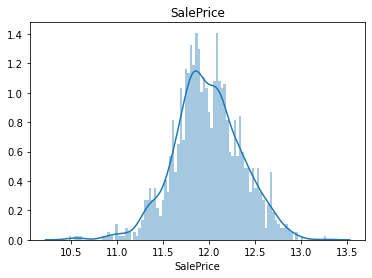

In [679]:
# Visualise the target variable -> SalePrice after transforming the sales price

first['SalePrice'] = np.log1p(first['SalePrice'])

plt.title('SalePrice')
sns.distplot(first['SalePrice'], bins=100)
plt.show()

<Figure size 720x360 with 0 Axes>

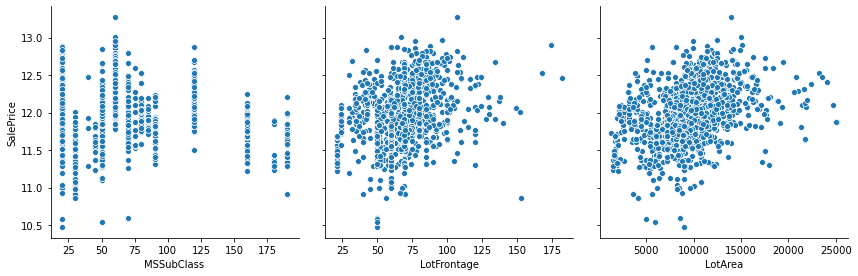

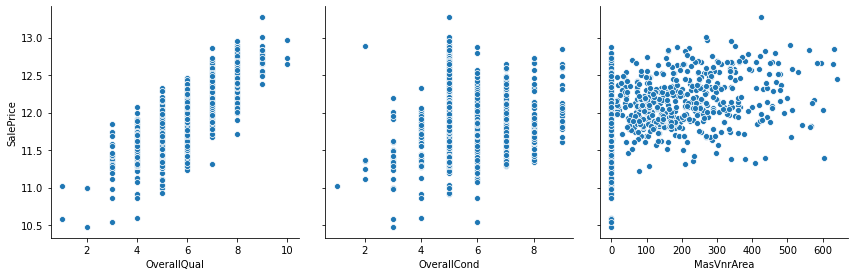

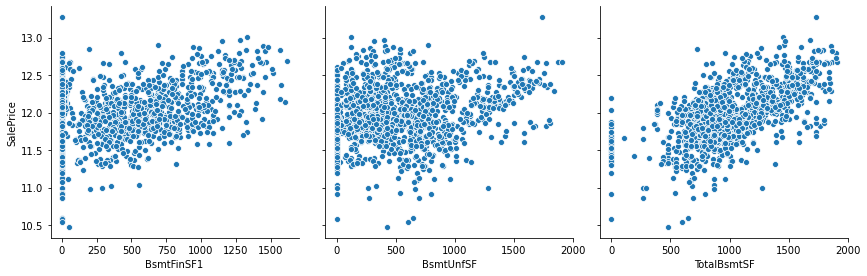

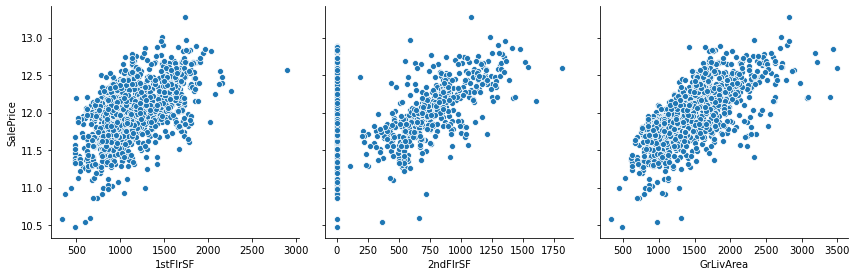

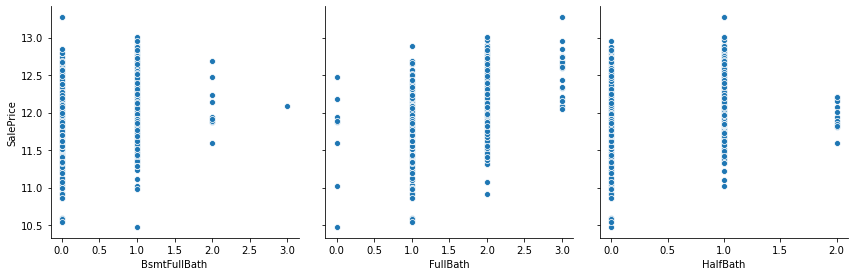

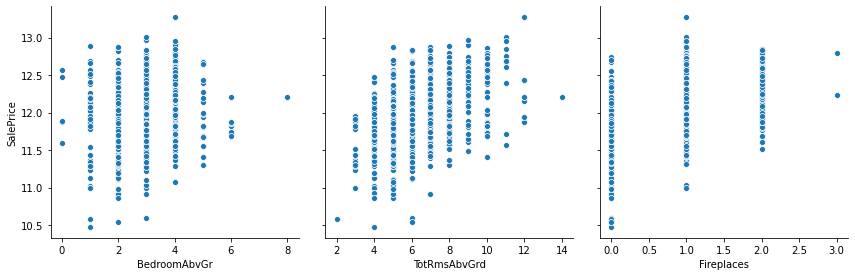

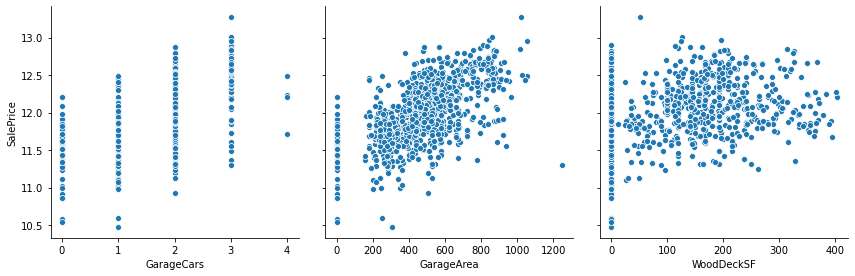

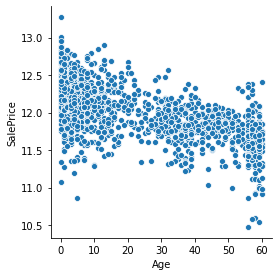

In [680]:
first# Check the numerical values using pairplots

plt.figure(figsize=(10,5))
sns.pairplot(first, x_vars=['MSSubClass','LotFrontage','LotArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(first, x_vars=['OverallQual', 'OverallCond','MasVnrArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(first, x_vars=['BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(first, x_vars=['1stFlrSF','2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(first, x_vars=['BsmtFullBath','FullBath', 'HalfBath'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(first, x_vars=['BedroomAbvGr','TotRmsAbvGrd', 'Fireplaces'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(first, x_vars=['GarageCars','GarageArea', 'WoodDeckSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')

sns.pairplot(first, x_vars=['Age'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
plt.show()

Observations :
    - 1stFlrSF, GrLivArea seems to be showing correlation towards right

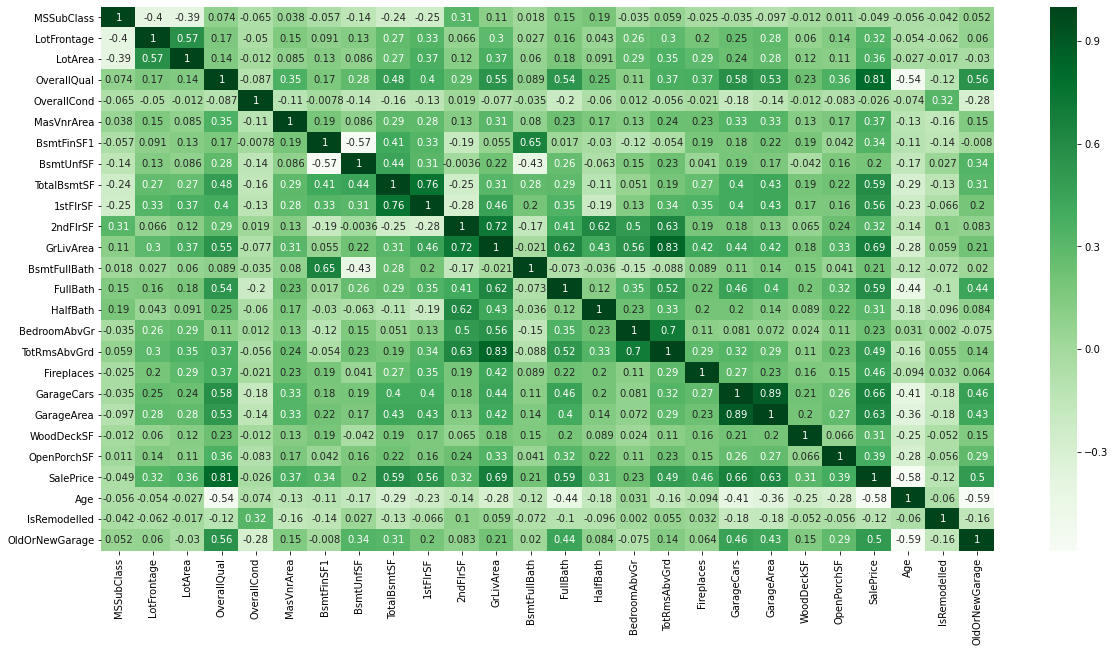

In [681]:
#Corelation Matrix

plt.figure(figsize = (20, 10))
sns.heatmap(first.corr(), annot = True, cmap="Greens")
plt.show()

#### Removing following columns which shows high correlation
    - TotRmsAbvGrd and GrLivArea show 82%
    - Garage Area and Garage Cars show 88%

Hence dropping TotRmsAbvGrd and Garage Cars

In [682]:
# Removing the highly correlated variables

first.drop(['TotRmsAbvGrd', 'GarageArea'], axis = 1, inplace = True)

In [683]:
# Check the shape of the dataframe

first.shape

(1317, 46)

## Data Preparation

  - Converting categorical data into numercal data 
  - Creating Dummies

In [684]:
# Since the values of the following fields are ordered list, we shall assign values to them in sequence

# For values which can be ordered, we have given an ordered sequence value
# For values which cannot be ordered, we have categorised them into 0 and 1

first['d_LotShape']     = first['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
first['d_ExterQual']    = first['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })
first['d_BsmtQual']     = first['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
first['d_BsmtExposure'] = first['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
first['d_BsmtFinType1'] = first['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 
                                                     'None': 0})




first['d_MasVnrType']   = first['MasVnrType'].map({'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0 })
first['d_SaleCondition']= first['SaleCondition'].map({'Normal': 1, 'Partial': 1, 'Abnorml': 0, 'Family': 0, 
                                                      'Alloca': 0, 'AdjLand': 0, 'None': 0})
first.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,OverallQual,...,Age,IsRemodelled,OldOrNewGarage,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_MasVnrType,d_SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,7,...,5,0,1,3,4,4,1,6,1,1
2,20,RL,80.0,9600,Reg,FR2,Veenker,1Fam,1Story,6,...,31,0,0,3,3,4,4,5,0,1
3,60,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,7,...,6,1,1,2,4,4,2,6,1,1
4,70,RL,60.0,9550,IR1,Corner,Crawfor,1Fam,2Story,7,...,36,1,0,2,3,3,1,5,0,0
5,60,RL,84.0,14260,IR1,FR2,NoRidge,1Fam,2Story,8,...,8,0,1,2,4,4,3,6,1,1


In [685]:
# drop the old columns from which the new columns were derived
# We can also drop the id column as it will not be used any more

first = first.drop(['LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 
                                'KitchenQual', 'FireplaceQu', 'GarageFinish', 'BldgType', 'HouseStyle', 'Fence', 
                                'LotConfig', 'MasVnrType', 'SaleCondition'], axis=1)

first.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,...,Age,IsRemodelled,OldOrNewGarage,d_LotShape,d_ExterQual,d_BsmtQual,d_BsmtExposure,d_BsmtFinType1,d_MasVnrType,d_SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,CollgCr,7,5,Gable,VinylSd,VinylSd,...,5,0,1,3,4,4,1,6,1,1
2,20,RL,80.0,9600,Veenker,6,8,Gable,MetalSd,MetalSd,...,31,0,0,3,3,4,4,5,0,1
3,60,RL,68.0,11250,CollgCr,7,5,Gable,VinylSd,VinylSd,...,6,1,1,2,4,4,2,6,1,1
4,70,RL,60.0,9550,Crawfor,7,5,Gable,Wd Sdng,Wd Shng,...,36,1,0,2,3,3,1,5,0,0
5,60,RL,84.0,14260,NoRidge,8,5,Gable,VinylSd,VinylSd,...,8,0,1,2,4,4,3,6,1,1


In [686]:

# Creating dummies 

categorical_var = ['MSZoning' , 'Neighborhood' , 'RoofStyle' , 'Exterior1st','Exterior2nd','Foundation','GarageType']

for i in categorical_var:
    df_1 = pd.get_dummies(first[i], drop_first=True,prefix =i)
    first = pd.concat([first,df_1],axis=1)
    first.drop(i,axis=1,inplace=True)


first.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,196.0,706,150,856,856,...,1,0,0,0,1,0,0,0,0,0
2,20,80.0,9600,6,8,0.0,978,284,1262,1262,...,0,0,0,0,1,0,0,0,0,0
3,60,68.0,11250,7,5,162.0,486,434,920,920,...,1,0,0,0,1,0,0,0,0,0
4,70,60.0,9550,7,5,0.0,216,540,756,961,...,0,0,0,0,0,0,0,0,1,0
5,60,84.0,14260,8,5,350.0,655,490,1145,1145,...,1,0,0,0,1,0,0,0,0,0


In [687]:
first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 1 to 1459
Columns: 104 entries, MSSubClass to GarageType_None
dtypes: float64(3), int64(28), uint8(73)
memory usage: 423.1 KB


All columns in the data set are now numeric !!!

## Train Test Split

In [688]:
# Putting all feature variable to X

X = first.drop(['SalePrice'], axis=1)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,196.0,706,150,856,856,...,1,0,0,0,1,0,0,0,0,0
2,20,80.0,9600,6,8,0.0,978,284,1262,1262,...,0,0,0,0,1,0,0,0,0,0
3,60,68.0,11250,7,5,162.0,486,434,920,920,...,1,0,0,0,1,0,0,0,0,0
4,70,60.0,9550,7,5,0.0,216,540,756,961,...,0,0,0,0,0,0,0,0,1,0
5,60,84.0,14260,8,5,350.0,655,490,1145,1145,...,1,0,0,0,1,0,0,0,0,0


In [689]:
# Putting response variable to y

y = first['SalePrice']
y.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

#### Feature Scaling

In [690]:

from sklearn.preprocessing import scale


cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'GarageType_Attchd', 'GarageType_Basment',
       'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd',
       'GarageType_None'],
      dtype='object', length=103)

### Train Test Split

In [691]:
# split into train and test

from sklearn.model_selection import train_test_split

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=42)

In [692]:
from sklearn.preprocessing import MinMaxScaler



### Recursive feature elimination (RFE)¶


In [693]:
# Running RFE with the output number of the variable equal to 30

lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm, 30)            
rfe = rfe.fit(X_train, y_train)

In [694]:
y_pred = rfe.predict(X_test)

In [695]:
# R2Score using RFE
r2_score(y_pred,y_test)

0.887706937623594

In [696]:
col = X_train.columns[rfe.support_]

# assign the 30 features selected using RFE to a dataframe and view them

temp_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), columns=['Variable', 'rfe_support', 'rfe_ranking'])
temp_df = temp_df.loc[temp_df['rfe_support'] == True]
temp_df.reset_index(drop=True, inplace=True)

temp_df

,Variable,rfe_support,rfe_ranking
0,MSSubClass,True,1
1,LotArea,True,1
2,OverallQual,True,1
3,OverallCond,True,1
4,BsmtFinSF1,True,1
5,BsmtUnfSF,True,1
6,TotalBsmtSF,True,1
7,GrLivArea,True,1
8,FullBath,True,1
9,HalfBath,True,1


In [697]:
# Assign the 30 columns to X_train_rfe

X_train_rfe = X_train[col]

In [698]:
# Associate the new 30 columns to X_train and X_test for further analysis

X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

##  Model Building and Evaluation

#### Ridge

In [699]:

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    2.9s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [700]:
# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
13,2,-0.078868,-0.083910,1
12,1,-0.078870,-0.083929,2
11,0.9,-0.078870,-0.083931,3
10,0.8,-0.078870,-0.083933,4
9,0.7,-0.078871,-0.083936,5
14,3,-0.078868,-0.083937,6
8,0.6,-0.078871,-0.083938,7
7,0.5,-0.078871,-0.083940,8
6,0.4,-0.078871,-0.083942,9
5,0.3,-0.078872,-0.083945,10


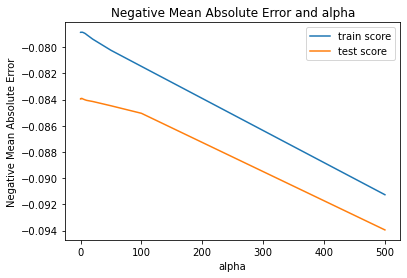

In [701]:
# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [702]:
ridge_model_cv.best_estimator_

Ridge(alpha=2.0)

In [703]:
alpha = 2
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-0.02244034,  0.02028591,  0.08873798,  0.04076704,  0.014695  ,
       -0.03126529,  0.06710515,  0.10369086,  0.01737499,  0.02112728,
        0.01765172,  0.03393149, -0.02769756,  0.02091262,  0.01847834,
        0.02250463,  0.01566248,  0.06960209,  0.03443475,  0.14544941,
        0.10365332,  0.01717514,  0.01364662,  0.02082102,  0.01525015,
       -0.02187298,  0.03267133,  0.05900416,  0.02660367, -0.01824717])

In [704]:
# mean squared error

mean_squared_error(y_test, ridge.predict(X_test))

0.014728514702601472

In [705]:
y_pred = ridge.predict(X_test)

In [706]:
r2_score(y_pred,y_test)

0.8881435303685186

In [707]:
# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)

ridge_df = ridge_df.sort_values(by=['Coefficient'], ascending=False)
ridge_df

,Features,Coefficient
19,MSZoning_RL,0.1454
20,MSZoning_RM,0.1037
7,GrLivArea,0.1037
2,OverallQual,0.0887
17,MSZoning_FV,0.0696
6,TotalBsmtSF,0.0671
27,Foundation_PConc,0.0590
3,OverallCond,0.0408
18,MSZoning_RH,0.0344
11,GarageCars,0.0339


#### Lasso

In [708]:
#Hashed for removing top five features for subjective questions

#X_train = X_train.drop(['MSZoning_RL' , 'GrLivArea' , 'MSZoning_RM' , 'OverallQual' , 'MSZoning_FV' ],axis =1)
#X_test = X_test.drop(['MSZoning_RL' , 'GrLivArea' , 'MSZoning_RM' , 'OverallQual' , 'MSZoning_FV' ],axis =1)

lasso = Lasso()

# list of alphas

params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

# cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.1s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [709]:
# display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
0,0.0001,-0.078864,-0.083957,1
1,0.0002,-0.078858,-0.083965,2
2,0.0003,-0.078858,-0.083993,3
3,0.0004,-0.078868,-0.084052,4
4,0.0005,-0.078890,-0.084114,5
5,0.001,-0.079115,-0.084474,6
6,0.002,-0.079971,-0.085039,7
7,0.003,-0.080938,-0.085681,8
8,0.004,-0.081758,-0.086356,9
9,0.005,-0.082659,-0.087084,10


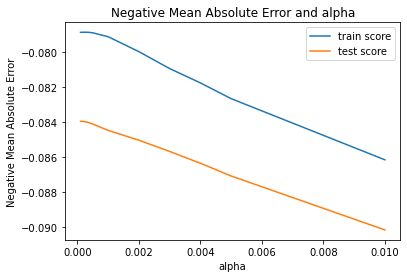

In [710]:
# plotting mean test and train scoes with alpha 

lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting

plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [711]:
# get the best estimator for lambda

lasso_model_cv.best_estimator_

Lasso(alpha=0.0001)

In [712]:
# check the coefficient values with lambda = 0.0001

alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([-0.02233148,  0.02019794,  0.08882216,  0.04052238,  0.01421536,
       -0.03165247,  0.06734635,  0.10440244,  0.01677376,  0.02069562,
        0.01746025,  0.03414716, -0.02763553,  0.02087537,  0.0184099 ,
        0.02250002,  0.01548763,  0.07364276,  0.03622012,  0.15275328,
        0.10992925,  0.01707371,  0.01351934,  0.02040559,  0.01508822,
       -0.02187349,  0.03265115,  0.0590695 ,  0.02639739, -0.0180935 ])

In [713]:
# Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))

0.014749801326721792

In [714]:
# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)

lasso_df = lasso_df.sort_values(by=['Coefficient'], ascending=False)
lasso_df

,Features,Coefficient
19,MSZoning_RL,0.1528
20,MSZoning_RM,0.1099
7,GrLivArea,0.1044
2,OverallQual,0.0888
17,MSZoning_FV,0.0736
6,TotalBsmtSF,0.0673
27,Foundation_PConc,0.0591
3,OverallCond,0.0405
18,MSZoning_RH,0.0362
11,GarageCars,0.0341


In [715]:
y_pred = lasso.predict(X_test)

In [716]:
r2_score(y_pred,y_test)

0.8880132225398967

## Conclusion :

- The optimal lambda value in case of Ridge and Lasso is as below:
    - Ridge - 2
    - Lasso - 0.0001
    
- The R2Score in case of Ridge and Lasso are:
    - Ridge - 88.8%
    - Lasso - 89.1%

- The R2Score of Lasso is slightly higher than that of Ridge

- Also, since Lasso helps in feature reduction (as the coefficient value of one of the feature became 0), Lasso has a 
  better edge over Ridge.
  
- Hence based on Lasso, the factors that generally affect the price are the Zoning classification, Living area
  square feet, Overall quality and condition of the house, Foundation type of the house, Number of cars that can be 
  accomodated in the garage, Total basement area in square feet and the Basement finished square feet area 
    
    * MSZoning_RL
    * GrLivArea
    * MSZoning_RM
    * OverallQual
    * MSZoning_FV